## Split training dataset to train and valid dataset (70/20/10)

In [4]:
import json
from collections import defaultdict

def analyze_coco_dataset(ann_file):
    # Load COCO annotations
    with open(ann_file, "r") as f:
        coco = json.load(f)

    # Build category mapping
    categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

    # Track images per class
    class_to_images = defaultdict(set)  # use set to avoid double counting
    for ann in coco["annotations"]:
        class_id = ann["category_id"]
        image_id = ann["image_id"]
        class_to_images[class_id].add(image_id)

    # Print summary
    print("Categories in dataset:")
    for class_id, class_name in categories.items():
        num_images = len(class_to_images[class_id])
        print(f"ID: {class_id}, Name: {class_name}, Images: {num_images}")

    print("\nTotal categories:", len(categories))
    print("Total images:", len(coco["images"]))


In [8]:
# Example usage
ann_file = r"data\merged_dataset\train\_annotations.coco.json"
analyze_coco_dataset(ann_file)

Categories in dataset:
ID: 0, Name: mahjong-vtacs-mexax-m4vyu-sjtd, Images: 0
ID: 1, Name: Bamboo 1, Images: 213
ID: 2, Name: Bamboo 2, Images: 185
ID: 3, Name: Bamboo 3, Images: 219
ID: 4, Name: Bamboo 4, Images: 200
ID: 5, Name: Bamboo 5, Images: 223
ID: 6, Name: Bamboo 6, Images: 215
ID: 7, Name: Bamboo 7, Images: 213
ID: 8, Name: Bamboo 8, Images: 243
ID: 9, Name: Bamboo 9, Images: 231
ID: 10, Name: Character 1, Images: 220
ID: 11, Name: Character 2, Images: 235
ID: 12, Name: Character 3, Images: 208
ID: 13, Name: Character 4, Images: 223
ID: 14, Name: Character 5, Images: 197
ID: 15, Name: Character 6, Images: 249
ID: 16, Name: Character 7, Images: 218
ID: 17, Name: Character 8, Images: 213
ID: 18, Name: Character 9, Images: 190
ID: 19, Name: Circle 1, Images: 206
ID: 20, Name: Circle 2, Images: 213
ID: 21, Name: Circle 3, Images: 226
ID: 22, Name: Circle 4, Images: 229
ID: 23, Name: Circle 5, Images: 241
ID: 24, Name: Circle 6, Images: 217
ID: 25, Name: Circle 7, Images: 251
ID: 

In [6]:
# Example usage
ann_file = r"data\California_vehicle_dataset\train\train\_annotations.coco.json"
analyze_coco_dataset(ann_file)

Categories in dataset:
ID: 0, Name: three_wheels, Images: 237
ID: 1, Name: bus, Images: 250
ID: 2, Name: car, Images: 277
ID: 3, Name: tractor, Images: 0
ID: 4, Name: truck, Images: 270
ID: 5, Name: ambulance, Images: 0
ID: 6, Name: van, Images: 256
ID: 7, Name: motorbikes, Images: 257

Total categories: 8
Total images: 1470


## Training on Merge Dataset

In [10]:
model.train(
    dataset_dir=r"data\merged_dataset",
    epochs=50,
    batch_size=4,
    grad_accum_steps=4,
    lr=1e-4,
    output_dir=r"data/output_rfdetr_merge_dataset",
    resume=r"data\output_rfdetr_merge_dataset\checkpoint.pth",
    eval=True   # 👈 force evaluation so test_stats gets defined
)

num_classes mismatch: model has 90 classes, but your dataset has 8 classes
reinitializing your detection head with 8 classes.


Unable to initialize TensorBoard. Logging is turned off for this session.  Run 'pip install tensorboard' to enable logging.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=8, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=50, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=16,

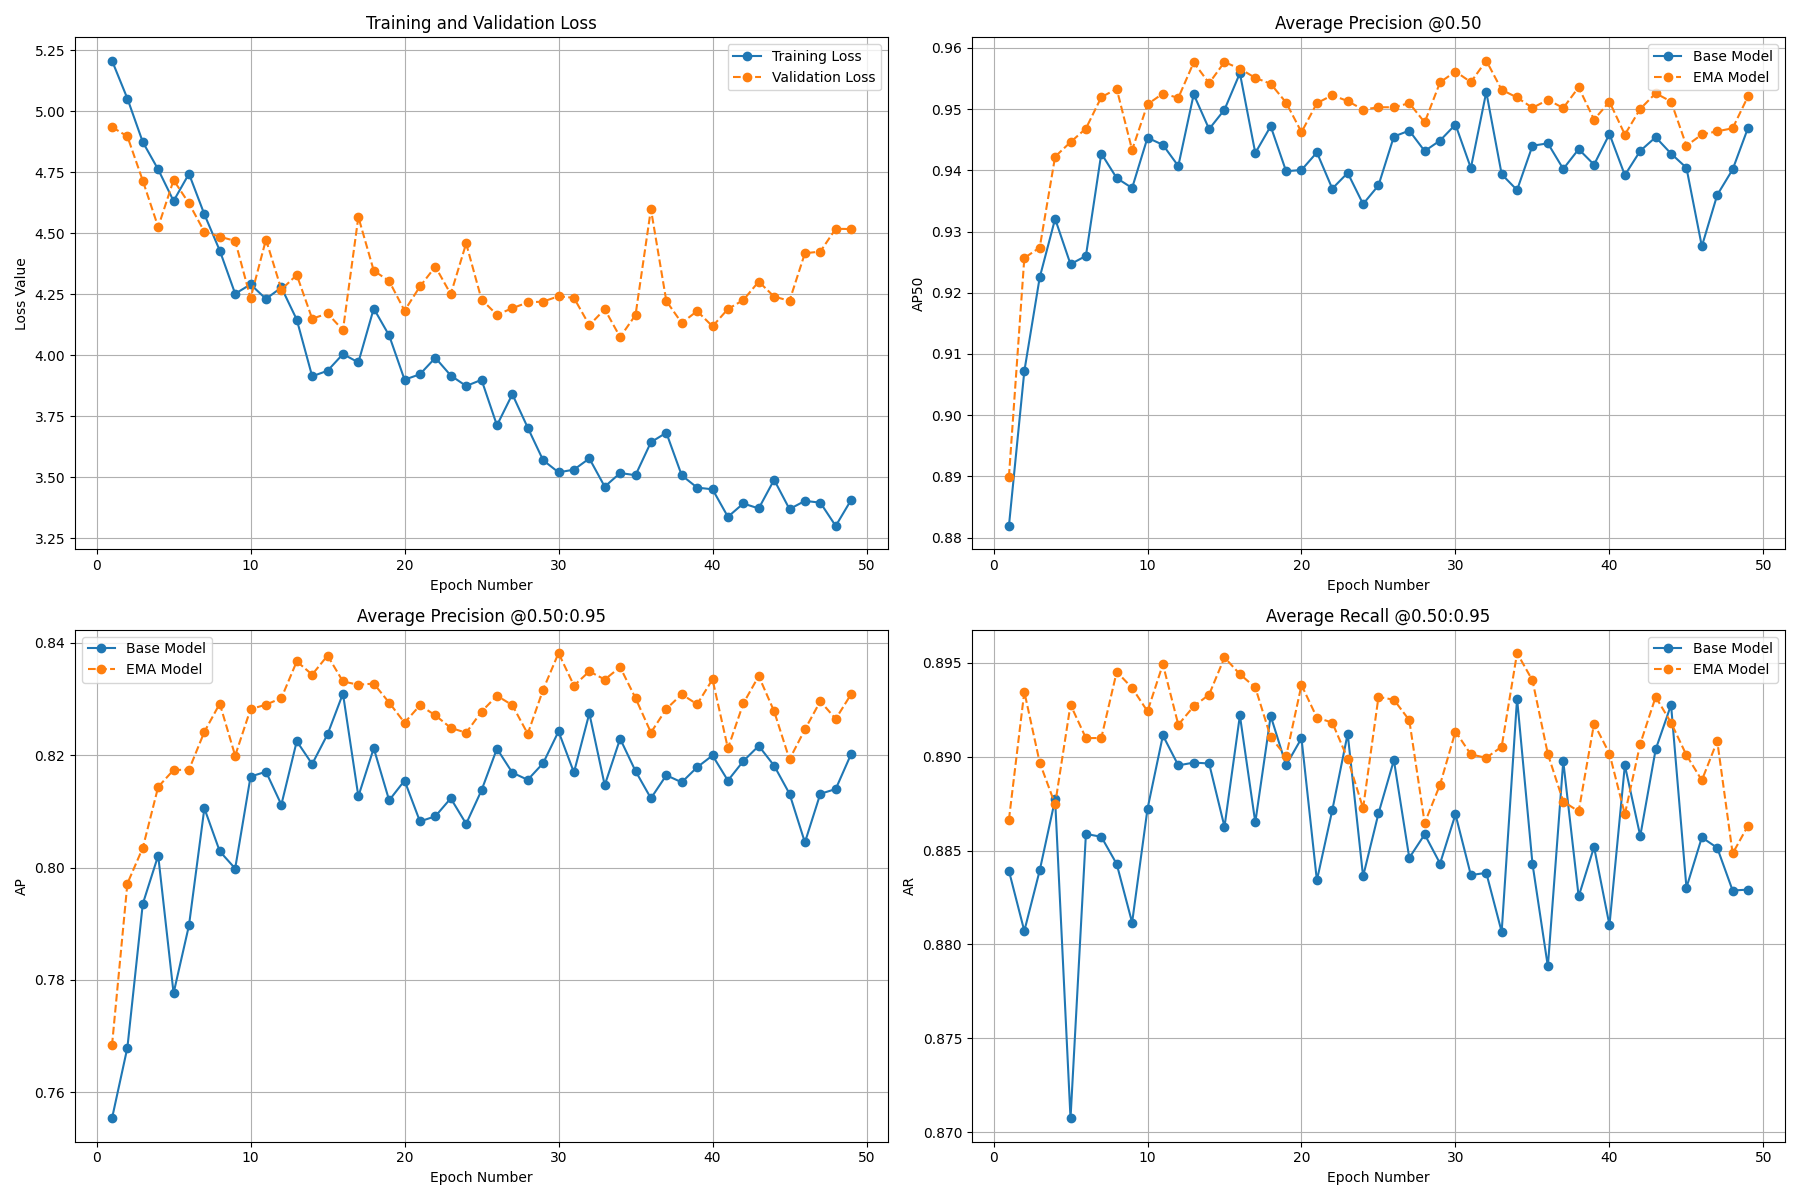

In [11]:
from PIL import Image

Image.open("data/output_rfdetr_merge_dataset/metrics_plot.png")

In [ ]:
import os
from PIL import Image
import supervision as sv
from rfdetr import RFDETRMedium   

dataset_dir = r"data/merged_dataset"
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_dir}/test",
    annotations_path=f"{dataset_dir}/test/_annotations.coco.json",
)

In [ ]:
import os
from PIL import Image
import supervision as sv
from rfdetr import RFDETRMedium   

dataset_dir = r"data/merged_dataset"
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_dir}/test",
    annotations_path=f"{dataset_dir}/test/_annotations.coco.json",
)

model = RFDETRMedium(
    model = RFDETRMedium(
    checkpoint_path = r"data/output_rfdetr_merge_dataset/checkpoint_best_ema.pth",
    device="cuda"  # or "cpu"
),
    device="cuda"  # or "cpu"
)

path, image, annotations = ds[1]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])


In [21]:
import os
from PIL import Image
import supervision as sv
from rfdetr import RFDETRMedium   # 👈 using Medium

# ----------------------------
# 1. Load Dataset
# ----------------------------
dataset_dir = r"data/merged_dataset"
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_dir}/test",
    annotations_path=f"{dataset_dir}/test/_annotations.coco.json",
)

# ----------------------------
# 2. Load Trained Model
# ----------------------------
# 👇 Initialize directly with checkpoint
model = RFDETRMedium(
    checkpoint_path = r"data\output_rfdetr_medium_autorickshaw\checkpoint_best_ema.pth",
    device="cuda"  # or "cpu"
)

# ----------------------------
# 3. Prepare Output Directory
# ----------------------------
save_dir = r"data/output_rfdetr_merge_dataset/test_results"
os.makedirs(save_dir, exist_ok=True)

# ----------------------------
# 4. Run Inference on Test Dataset
# ----------------------------
for idx, (path, image, annotations) in enumerate(ds):
    image = Image.open(path).convert("RGB")

    # Run inference
    detections = model.predict(image, threshold=0.5)

    # Dynamic visualization parameters
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    # Annotators
    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True
    )

    # Detection labels (safe against out-of-range indices)
    detections_labels = []
    for class_id, confidence in zip(detections.class_id, detections.confidence):
        if 0 <= class_id < len(ds.classes):
            label = ds.classes[class_id]
        else:
            label = "Unknown"
        detections_labels.append(f"{label} {confidence:.2f}")

    # Annotated image
    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    # Save annotated image
    save_path = os.path.join(save_dir, f"test_{idx}.jpg")
    detections_image.save(save_path)

print(f"\nInference complete! Results saved in: {save_dir}")


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().



Inference complete! Results saved in: data/output_rfdetr_merge_dataset/test_results
